# Touchscreen Dataset Analysis

### Package Import and Path Configuration
This section imports all required packages and defines the file paths needed for the analysis.

In [26]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.experimental import enable_iterative_imputer  # IterativeImputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from scipy import stats
import math

# Set the path to the directory containing the raw data files
path = "../main/data/UK_BIOBANK_DATA" 
path_graphs = "../main/doutputs/graphs" 
path_results = "../main/doutputs/results" 

The phenotype dataset is loaded. This dataset is provided with a tab separator format. For that reason, the following code was used.

In [3]:
#Charge dataframes
#Touchscreen
touchscreen_df = pd.read_csv(os.path.join(path, "touchscreen_data.tsv"), sep="\t")

In [4]:
# Display the first few rows of the touchscreen data
touchscreen_df.head()

,eid,f_670_0_0,f_670_1_0,f_670_2_0,f_670_3_0,f_680_0_0,f_680_1_0,f_680_2_0,f_680_3_0,f_699_0_0,...,f_22037_2_0,f_22037_3_0,f_22038_0_0,f_22038_1_0,f_22038_2_0,f_22038_3_0,f_22039_0_0,f_22039_1_0,f_22039_2_0,f_22039_3_0
0,1000012,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1000021,1.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,24.0,...,NaN,NaN,4320.0,NaN,NaN,NaN,320.0,NaN,NaN,NaN
2,1000035,1.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,10.0,...,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN
3,1000044,1.0,1.0,NaN,NaN,2.0,2.0,NaN,NaN,27.0,...,NaN,NaN,0.0,240.0,NaN,NaN,0.0,960.0,NaN,NaN
4,1000053,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,32.0,...,NaN,NaN,240.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN


The chars dataset is loaded, which contains information relevant to the original dataset. This is done to gain more information, better understand the dataset, and make future associations.

In [5]:
# Olink Characters
# Open the original TSV file and skip the first 5 header lines
with open(os.path.join(path, 'touchscreen_chars.tsv'), 'r') as f:
    # Read all lines and discard the first five
    lines = f.readlines()[5:]

# Write the remaining lines to a new TSV file
with open(os.path.join(path, 'touchscreen_chars_table.tsv'), 'w') as f:
    # Output the extracted lines without modification
    f.writelines(lines)

In [6]:
# Load the filtered TSV into a DataFrame, using tab as the separator
touchscreen_chars_df = pd.read_csv(
    os.path.join(path, 'touchscreen_chars_table.tsv'),
    sep="\t"
)

# Create a new column for protein names and reorder the DataFrame
# Get the list of existing column names
cols = touchscreen_chars_df.columns.tolist()

# Insert a 'pname' column just before 'ValueType', extracting
# the protein name from the 'Field' column (text before the first semicolon)
touchscreen_chars_df.insert(
    cols.index('ValueType'),
    'pname',
    touchscreen_chars_df['Field'].str.split(";").str[0]
)

# Display the first few rows of the updated DataFrame
touchscreen_chars_df.head()

,Field,FieldID,pname,ValueType,Coding,Category,Participants,Items,Stability,Units,ItemType,Strata,Sexed,Instances,Array,Notes,Link,Path
0,Type of accommodation lived in,670,Type of accommodation lived in,Categorical single,100286.0,100066,501527,597706,Complete,NaN,Data,Primary,Unisex,4,1,"ACE touchscreen question """"""""What type of acco...",http://biobank.ndph.ox.ac.uk/ukb/field.cgi?id=670,Assessment centre > Touchscreen > Sociodemogra...
1,Own or rent accommodation lived in,680,Own or rent accommodation lived in,Categorical single,100287.0,100066,500149,596187,Complete,NaN,Data,Primary,Unisex,4,1,"ACE touchscreen question """"""""Do you own or ren...",http://biobank.ndph.ox.ac.uk/ukb/field.cgi?id=680,Assessment centre > Touchscreen > Sociodemogra...
2,Length of time at current address,699,Length of time at current address,Integer,100290.0,100066,501523,597702,Complete,years,Data,Primary,Unisex,4,1,"ACE touchscreen question """"""""How many years ha...",http://biobank.ndph.ox.ac.uk/ukb/field.cgi?id=699,Assessment centre > Touchscreen > Sociodemogra...
3,Number in household,709,Number in household,Integer,100291.0,100066,500147,596185,Complete,people,Data,Primary,Unisex,4,1,"ACE touchscreen question """"""""Including yoursel...",http://biobank.ndph.ox.ac.uk/ukb/field.cgi?id=709,Assessment centre > Touchscreen > Sociodemogra...
4,Number of vehicles in household,728,Number of vehicles in household,Categorical single,100293.0,100066,500147,596185,Complete,NaN,Data,Primary,Unisex,4,1,"ACE touchscreen question """"""""How many cars or ...",http://biobank.ndph.ox.ac.uk/ukb/field.cgi?id=728,Assessment centre > Touchscreen > Sociodemogra...


## Preprocessing

### Missing Values

In [7]:
# Extract unique suffixes from column names (excluding 'eid')
col_names = touchscreen_df.columns
suffixes = []

# Loop through each column name
for col in col_names:
    if col!= 'eid':
        # Split the column name by underscores
        parts = col.split('_')
        # If the column name has at least 4 parts, extract the 3rd and 4th parts as the suffix
        if len(parts) >= 4:
            suffixes_p = f"{parts[2]}_{parts[3]}" 
            suffixes.append(suffixes_p)

# Get a sorted list of unique suffixes found in the column names
unique_suffixes = sorted(set(suffixes))
print(unique_suffixes)

['0_0', '0_1', '0_2', '0_3', '0_4', '0_5', '0_6', '1_0', '1_1', '1_2', '1_3', '1_4', '2_0', '2_1', '2_2', '2_3', '2_4', '2_5', '3_0', '3_1', '3_2', '3_3']


In [8]:
for suffix in unique_suffixes:
    # Filter columns by the current suffix
    suffix_cols = touchscreen_df.filter(regex=fr'{suffix}$')
    
    # Calculate total NA values and total cells (rows × columns)
    total_na = suffix_cols.isna().sum().sum()
    total_cells = suffix_cols.size  # Equivalent to: rows × columns
    
    # Avoid division by zero if no columns match the suffix
    if total_cells == 0:
        print(f"No columns found with suffix '{suffix}'")
        continue
    
    # Compute percentage of NA values
    na_percentage = (total_na / total_cells) * 100
    
    # Print results
    print(f"Suffix '{suffix}': {total_na} NA values ({na_percentage:.2f}%)")

Suffix '0_0': 90061049 NA values (47.32%)
Suffix '0_1': 15148149 NA values (81.53%)
Suffix '0_2': 15173220 NA values (94.42%)
Suffix '0_3': 7778577 NA values (96.81%)
Suffix '0_4': 4466925 NA values (98.83%)
Suffix '0_5': 2501892 NA values (99.64%)
Suffix '0_6': 500527 NA values (99.67%)
Suffix '1_0': 154342408 NA values (97.26%)
Suffix '1_1': 11408922 NA values (98.78%)
Suffix '1_2': 5988521 NA values (99.38%)
Suffix '1_3': 2500727 NA values (99.59%)
Suffix '1_4': 501490 NA values (99.86%)
Suffix '2_0': 154733865 NA values (90.89%)
Suffix '2_1': 13632204 NA values (96.95%)
Suffix '2_2': 9409354 NA values (98.62%)
Suffix '2_3': 4480205 NA values (99.13%)
Suffix '2_4': 2503861 NA values (99.72%)
Suffix '2_5': 501677 NA values (99.90%)
Suffix '3_0': 138174108 NA values (98.97%)
Suffix '3_1': 8501108 NA values (99.58%)
Suffix '3_2': 3003144 NA values (99.67%)
Suffix '3_3': 1001419 NA values (99.71%)


According to the previous results, it is evident that the tests were conducted in three (3) stages. Across these stages, only instances 0 and 1 were retained. It can be observed that instance 0 contains fewer NA values from the stage 1. Therefore, instance 0 is selected for further analysis, as it corresponds to the stage with the least amount of missing data.

In [9]:
# Select columns that match the pattern 'f_\d+_0_\d+' and include 'eid'
# _instances_array 
# instances cohort 
# array number of options 
selected_columns = ['eid'] + [
    col for col in touchscreen_df.columns
    if re.match(r'^f_\d+_0_\d+$', col)
]

# Create a new DataFrame with the selected columns
touchscreen_dr_df = touchscreen_df[selected_columns]

# Display the first few rows of the new DataFrame
touchscreen_dr_df.head()


,eid,f_670_0_0,f_680_0_0,f_699_0_0,f_709_0_0,f_728_0_0,f_738_0_0,f_757_0_0,f_767_0_0,f_777_0_0,...,f_20162_0_0,f_21000_0_0,f_22032_0_0,f_22033_0_0,f_22034_0_0,f_22035_0_0,f_22036_0_0,f_22037_0_0,f_22038_0_0,f_22039_0_0
0,1000012,1.0,1.0,4.0,3.0,3.0,3.0,NaN,NaN,NaN,...,NaN,1001.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1000021,1.0,2.0,24.0,4.0,2.0,3.0,15.0,50.0,6.0,...,0.712500,1001.0,2.0,16.0,370.0,1.0,1.0,3564.0,4320.0,320.0
2,1000035,1.0,3.0,10.0,3.0,1.0,1.0,NaN,NaN,NaN,...,0.462963,1001.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1000044,1.0,2.0,27.0,4.0,3.0,2.0,3.0,35.0,5.0,...,NaN,1001.0,0.0,2.0,15.0,0.0,0.0,99.0,0.0,0.0
4,1000053,1.0,1.0,32.0,2.0,3.0,3.0,NaN,NaN,NaN,...,NaN,1001.0,1.0,10.0,50.0,0.0,1.0,693.0,240.0,0.0


In [10]:
# Size of the DataFrame after filtering
touchscreen_dr_df.shape

(502180, 480)

We verify whether duplicate records exist according to the 'eid' column.

In [11]:
# Check for duplicates in 'eid'
duplicates = touchscreen_dr_df[touchscreen_df["eid"].duplicated(keep=False)]

# Display duplicate rows (if any)
if not duplicates.empty:
    print(f"Found {len(duplicates)} duplicate rows in 'eid':")
    display(duplicates)
else:
    print("No duplicates found in 'eid'.")

No duplicates found in 'eid'.


The type of data contained in the dataset is verified

In [12]:
# Check data types of all columns
data_types = touchscreen_dr_df.dtypes

# Count the number of columns per data type
type_counts = data_types.value_counts()

# Print results
for dtype, count in type_counts.items():
    print(f"Data type: {dtype} | Number of columns: {count}")

print("\nTotal number of columns:", len(touchscreen_dr_df.columns))

Data type: float64 | Number of columns: 479
Data type: int64 | Number of columns: 1

Total number of columns: 480


With the dimensionality reduction previously performed, the amount of null data is looked at again.

In [13]:
missing_percentage = touchscreen_dr_df.isna().mean() * 100
#missing_percentage = missing_percentage[missing_percentage > 0].sort_values(ascending=False)
# Display the percentage of missing values for each column, with a % symbol
print("\nPercentage of missing values in each column:")
for col, pct in missing_percentage.items():
    print(f"{col}: {pct:.2f}%")


Percentage of missing values in each column:
eid: 0.00%
f_670_0_0: 0.17%
f_680_0_0: 0.45%
f_699_0_0: 0.17%
f_709_0_0: 0.45%
f_728_0_0: 0.45%
f_738_0_0: 1.20%
f_757_0_0: 42.87%
f_767_0_0: 42.87%
f_777_0_0: 43.33%
f_796_0_0: 47.15%
f_806_0_0: 42.87%
f_816_0_0: 42.87%
f_826_0_0: 42.87%
f_845_0_0: 32.98%
f_864_0_0: 0.17%
f_874_0_0: 4.90%
f_884_0_0: 0.18%
f_894_0_0: 18.20%
f_904_0_0: 0.18%
f_914_0_0: 41.35%
f_924_0_0: 0.56%
f_943_0_0: 1.31%
f_971_0_0: 30.16%
f_981_0_0: 30.16%
f_991_0_0: 90.04%
f_1001_0_0: 90.04%
f_1011_0_0: 50.54%
f_1021_0_0: 50.54%
f_1031_0_0: 0.93%
f_1050_0_0: 0.93%
f_1060_0_0: 0.93%
f_1070_0_0: 0.18%
f_1080_0_0: 0.93%
f_1090_0_0: 0.22%
f_1100_0_0: 0.22%
f_1110_0_0: 0.18%
f_1120_0_0: 15.76%
f_1130_0_0: 15.76%
f_1140_0_0: 15.76%
f_1150_0_0: 15.76%
f_1160_0_0: 0.18%
f_1170_0_0: 0.93%
f_1180_0_0: 0.93%
f_1190_0_0: 0.18%
f_1200_0_0: 0.18%
f_1210_0_0: 0.18%
f_1220_0_0: 0.18%
f_1239_0_0: 0.18%
f_1249_0_0: 7.99%
f_1259_0_0: 8.66%
f_1269_0_0: 7.91%
f_1279_0_0: 7.91%
f_1289_0_0: 

Attributes with a percentage greater than 90% will be eliminated from the analysis, following the recommendation made by UK Bank (the institution that owns the data).

In [14]:
touchscreen_dr_df = touchscreen_dr_df.loc[:, missing_percentage <= 90]

# Display the shape of the DataFrame after filtering
touchscreen_dr_df.shape

(502180, 292)

Elimination of non-relevant questions integer

| Field ID  | Question |
|-----------|-----------|
| 699       | Length of time at current address   |
| 709       | Number in household |
| 1070      | Time spent watching television (TV) |
| 1080      | Time spent using computer |
| 1845      | Mother's age |
| 2946      | Father's age |
| 3659      | Year immigrated to UK (United Kingdom) |
| 3672      | Number of adopted brothers |
| 3682      | Number of adopted sisters |

Elimination of non-relevant questions categorical single

| Field ID  | Question |
|-----------|-----------|
| 670       | Type of accommodation lived in   |
| 780       | Own or rent accommodation lived in |
| 1011      | Frequency of light DIY in last 4 weeks |
| 1021      | Duration of light DIY |
| 1031      | Frequency of friend/family visits |
| 1707      | Handedness (chirality/laterality) |
| 1767      | Adopted as a child |
| 1797      | Father still alive |
| 1835      | Mother still alive |
| 2237      | Plays computer games |
| 2624      | Frequency of heavy DIY in last 4 weeks |
| 2634      | Duration of heavy DIY |
| 3912      | Adopted father still alive |
| 3942      | Adopted mother still alive |
| 4825      | Noisy workplace |
| 4836      | Loud music exposure frequency |
| 10105     | Internet user (pilot) |
| 10114     | Willing to be contacted by email (pilot) |
| 10740     | Frequency of friend/family visits (pilot) |
| 10749     | Time using mobile phone in last 3 months (pilot) |
| 10818     | Reason for reducing amount of alcohol drunk (pilot) |
| 10877     | Average total household income before tax (pilot) |
| 10886     | Difference in mobile phone use compared to one year previously (pilot) |
| 20119     | Current employment status - corrected |


Elimination of non-relevant questions categorical multiple

| Field ID  | Question |
|-----------|-----------|
| 6138      | Qualifications  |
| 6139      | Gas or solid-fuel cooking/heating  |
| 6140      | Heating type(s) in home |
| 6143      | Transport type for commuting to job workplace |
| 6141      | How are people in household related to participant |
| 6142      | Current employment status |
| 10016     | Regular use of hands-free device/speakerphone with mobile phone (pilot) |
| 10015     | Why stopped smoking (pilot) |
| 20112     | Illnesses of adopted father |
| 20113     | Illnesses of adopted mother |
| 20114     | Illnesses of adopted siblings |


In [15]:
# List of irrelevant Field IDs to drop
irrelevant_ids = [
    # Integer
    "699", "709", "796" ,"1070", "1080", "1845", "2946", "3659", "3672", "3682",

    # Categorical single
    "670", "780", "1011", "1021", "1031", "1707", "1767", "1797", "1835",
    "2237", "2624", "2634", "3912", "3942", "4825", "4836", "10105", "10114", "10740", 
    "10749", "10818", "10877", "10886", "20119",

    # Categorical multiple
    "6138", "6139", "6140", "6143", "6141", "6142", "10016", "10015", "20112"
]

# Create a regex pattern to match columns with the specified IDs
pattern = re.compile(rf"^f_({'|'.join(irrelevant_ids)})_\d+_\d+$")

# Find columns that match the pattern
columns_to_drop = [col for col in touchscreen_dr_df.columns if pattern.match(col)]

# Drop the identified columns from the DataFrame
touchscreen_dr_df = touchscreen_dr_df.drop(columns=columns_to_drop)

# Validate the drop by checking the remaining columns
touchscreen_dr_df.head()

,eid,f_680_0_0,f_728_0_0,f_738_0_0,f_757_0_0,f_767_0_0,f_777_0_0,f_806_0_0,f_816_0_0,f_826_0_0,...,f_20162_0_0,f_21000_0_0,f_22032_0_0,f_22033_0_0,f_22034_0_0,f_22035_0_0,f_22036_0_0,f_22037_0_0,f_22038_0_0,f_22039_0_0
0,1000012,1.0,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1001.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1000021,2.0,2.0,3.0,15.0,50.0,6.0,4.0,2.0,2.0,...,0.712500,1001.0,2.0,16.0,370.0,1.0,1.0,3564.0,4320.0,320.0
2,1000035,3.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.462963,1001.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1000044,2.0,3.0,2.0,3.0,35.0,5.0,2.0,1.0,4.0,...,NaN,1001.0,0.0,2.0,15.0,0.0,0.0,99.0,0.0,0.0
4,1000053,1.0,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1001.0,1.0,10.0,50.0,0.0,1.0,693.0,240.0,0.0


### Division de datos numericos y categoricos 

In [16]:
# Asegurar que FieldID sea entero
touchscreen_chars_df['FieldID'] = touchscreen_chars_df['FieldID'].astype(int)

# Crear diccionario FieldID → ValueType
valuetype_map = touchscreen_chars_df.set_index('FieldID')['ValueType'].to_dict()

# Mapear columnas de touchscreen_dr_df a sus FieldIDs usando regex
column_fieldid_map = {
    col: int(re.search(r'f_(\d+)_', col).group(1))
    for col in touchscreen_dr_df.columns
    if col.startswith('f_')
}

# Clasificación por tipo
numeric_cols = []
categorical_cols = []
unknown_cols = []

for col, fid in column_fieldid_map.items():
    vtype = valuetype_map.get(fid, 'Unknown').lower()
    if 'integer' in vtype or 'continuous' in vtype:
        numeric_cols.append(col)
    elif 'categorical' in vtype:
        categorical_cols.append(col)
    else:
        unknown_cols.append(col)

numeric_df = touchscreen_dr_df[['eid'] + numeric_cols]
categorical_df = touchscreen_dr_df[['eid'] + categorical_cols]

print(f"Número de columnas numéricas: {len(numeric_cols)}")
print(f"Número de columnas categóricas: {len(categorical_cols)}")
print(f"Columnas con tipo desconocido: {len(unknown_cols)}")

Número de columnas numéricas: 79
Número de columnas categóricas: 180
Columnas con tipo desconocido: 0


##### Procesamiento de datos numericos 

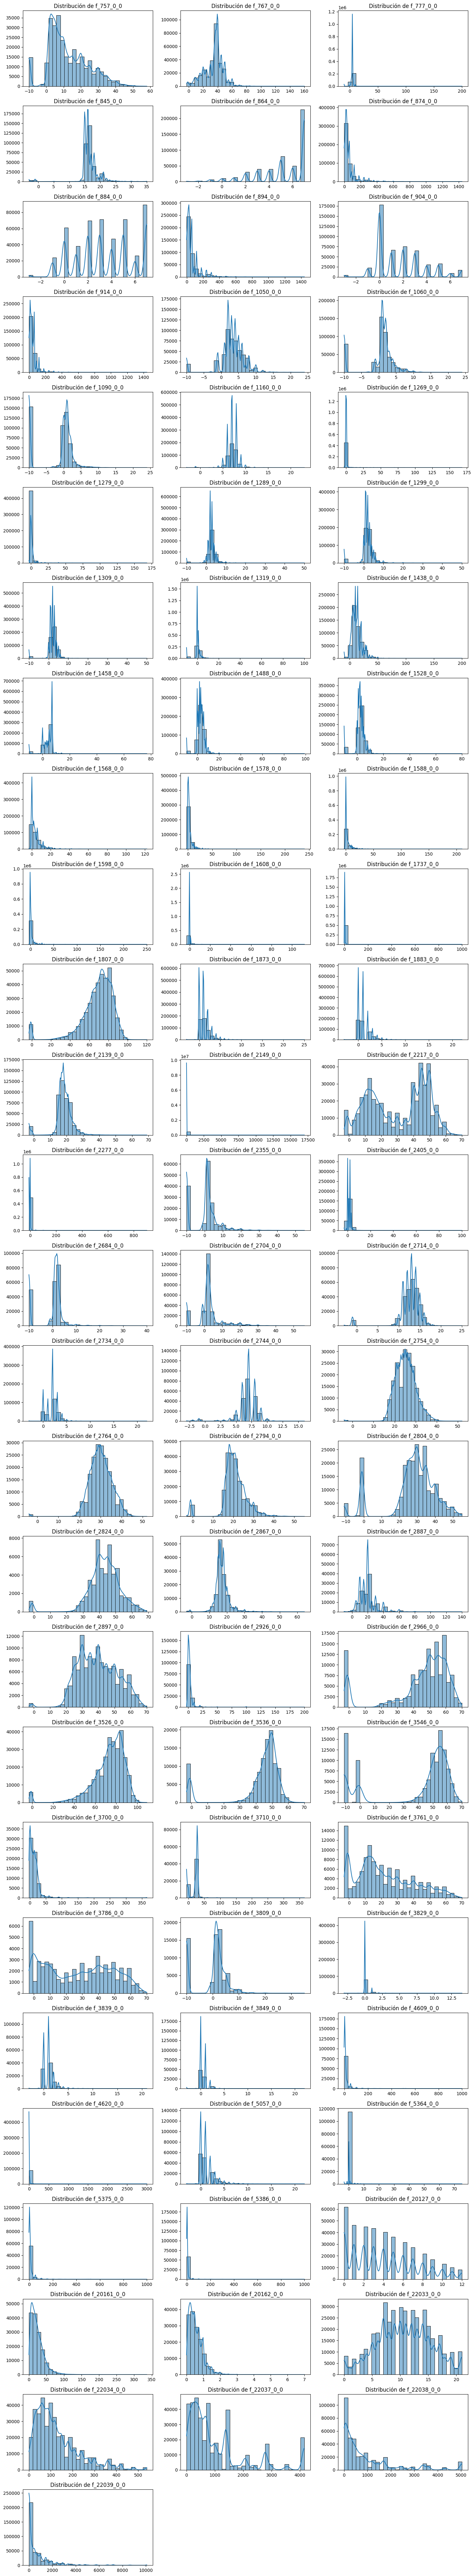

In [17]:
numeric_columns = numeric_df.columns.drop('eid')
num_plots = len(numeric_columns)

ncols = 3
nrows = math.ceil(num_plots / ncols)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows * 3))
axes = axes.flatten()

for i, col in enumerate(numeric_columns):
    sns.histplot(numeric_df[col], kde=True, ax=axes[i], bins=30)
    axes[i].set_title(f'Distribución de {col}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

# Si hay más subplots que columnas, apaga los sobrantes
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


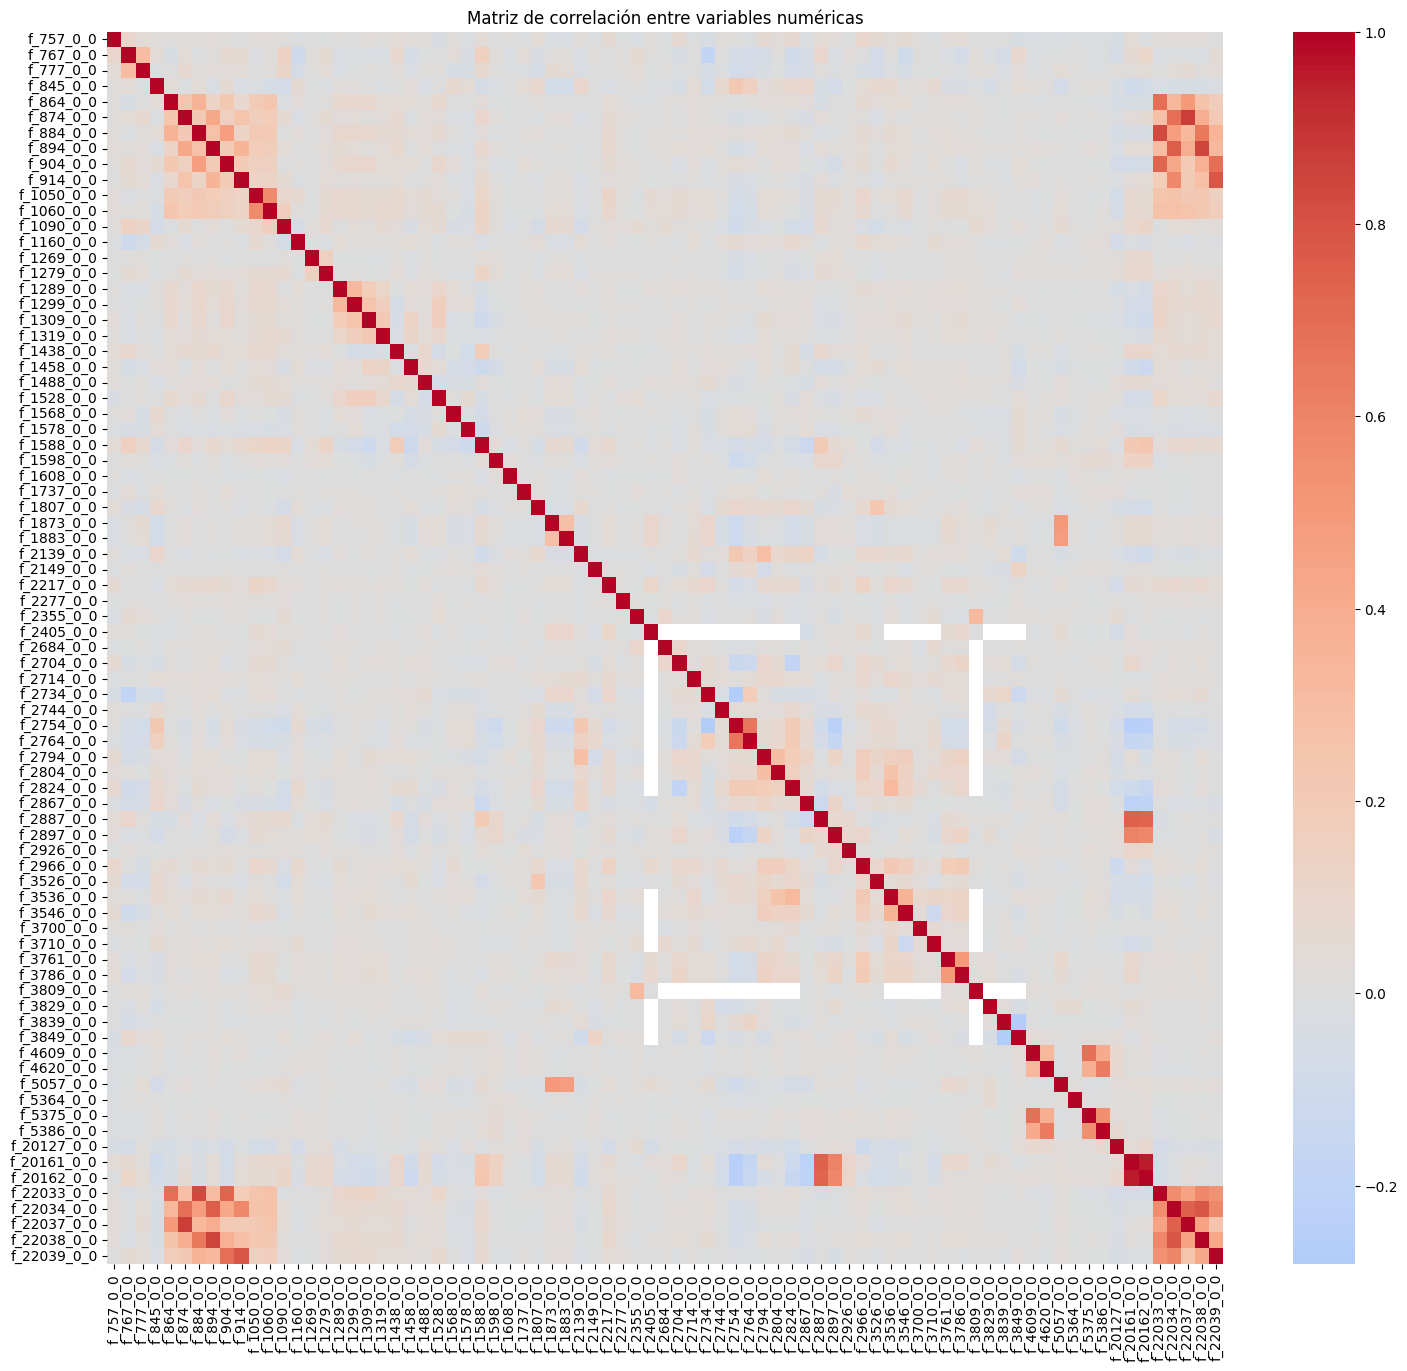

In [18]:
plt.figure(figsize=(18, 16))
corr = numeric_df.drop(columns='eid').corr()

sns.heatmap(corr, cmap='coolwarm', center=0, annot=False)
plt.title("Matriz de correlación entre variables numéricas")
plt.show()

In [19]:
# Calcular la matriz de correlación absoluta (sin 'eid')
corr_matrix = numeric_df.drop(columns='eid').corr().abs()

# Crear una máscara para obtener solo la parte superior de la matriz
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Extraer pares con correlación > 0.9
high_corr_pairs = (
    upper.stack()
    .reset_index()
    .rename(columns={0: 'correlation', 'level_0': 'Variable1', 'level_1': 'Variable2'})
)

# Filtrar los pares con correlación mayor a 0.9
high_corr_pairs = high_corr_pairs[high_corr_pairs['correlation'] > 0.9]

# Ordenar de mayor a menor
high_corr_pairs = high_corr_pairs.sort_values(by='correlation', ascending=False)

# Mostrar el resultado
print("Pares altamente correlacionados")
display(high_corr_pairs)  # o simplemente 'high_corr_pairs' si estás en Jupyter
 
print(numeric_df.shape)

Pares altamente correlacionados


,Variable1,Variable2,correlation
3026,f_20161_0_0,f_20162_0_0,0.954903


(502180, 80)


Las variables altamente correlacionadas son:

| id | Data|
|----|-----------|
| f_20161_0_0 | Pack years of smoking|
| f_20162_0_0 | Pack years adult smoking as proportion of life span exposed to smoking |

Por lo cual se procede a eliminar f_20161_0_0 

In [20]:
# List of irrelevant Field IDs to drop
irrelevant_ids = [
    # Integer
    "20161"

]

# Create a regex pattern to match columns with the specified IDs
pattern = re.compile(rf"^f_({'|'.join(irrelevant_ids)})_\d+_\d+$")

# Find columns that match the pattern
columns_to_drop = [col for col in numeric_df.columns if pattern.match(col)]

# Drop the identified columns from the DataFrame
numeric_df = numeric_df.drop(columns=columns_to_drop)

# Validate the drop by checking the remaining columns
print(numeric_df.shape)

(502180, 79)


Boxplots to see outliers

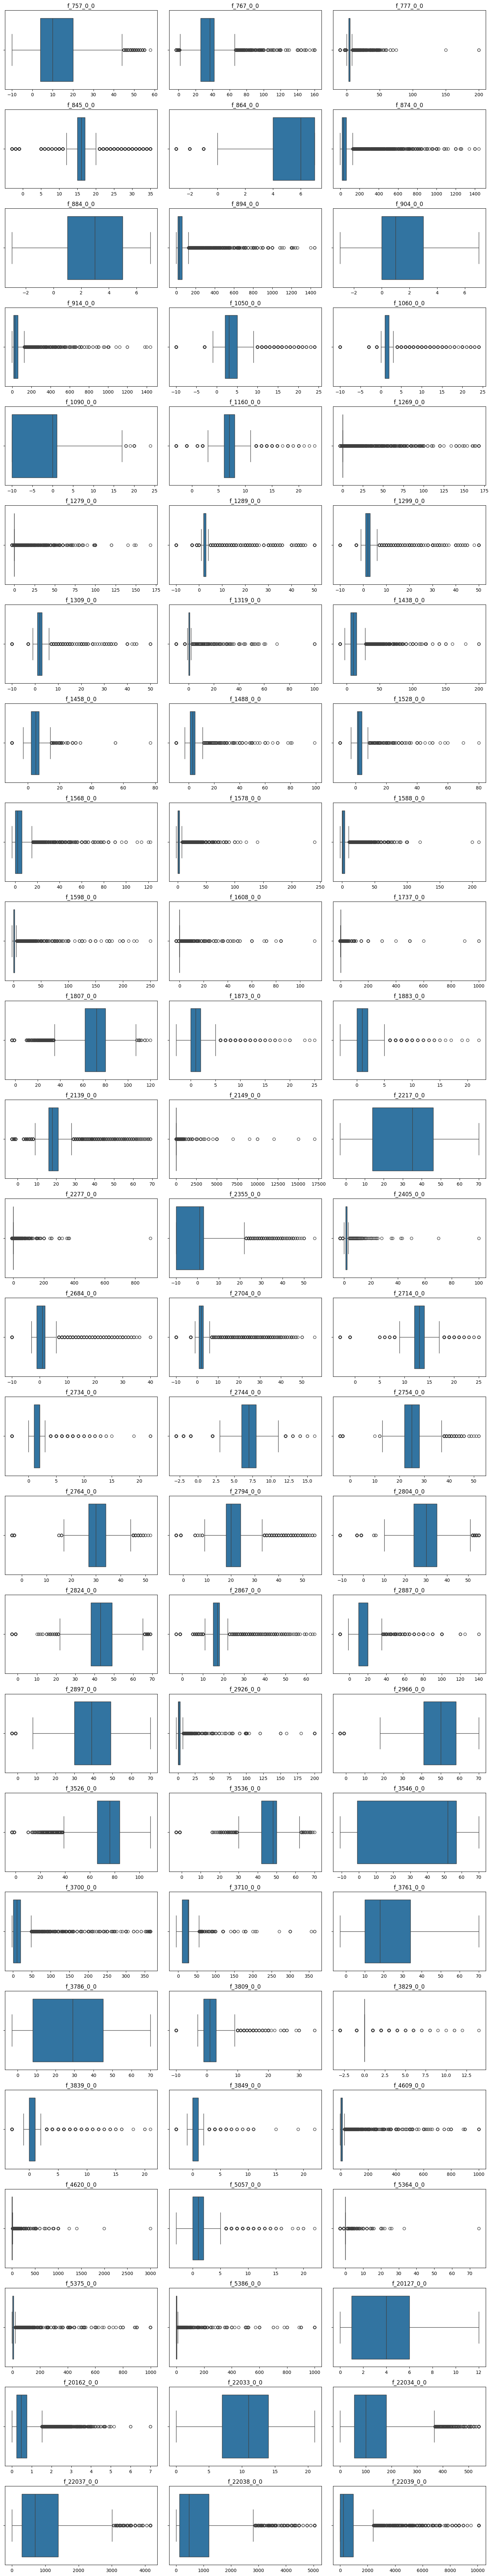

In [24]:
cols = numeric_df.columns.drop('eid')  # Quitamos la columna 'eid'
n = len(cols)
ncols = 3                              # 3 columnas
nrows = math.ceil(n / ncols)          # Número de filas necesario

# Crear una sola figura
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows * 3))
axes = axes.flatten()  # Para recorrerlos fácilmente

# Crear los boxplots
for i, col in enumerate(cols):
    sns.boxplot(x=numeric_df[col].dropna(), ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

# Apagar los ejes sobrantes si hay menos gráficos que subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


Como se maneja un data set con gran cantidad de datos y con varias dimensiones, se decide para la imputacion la utilizacion de isolation forest. Para esto se hace la normalizacion de los datos para luego implementar el modelo para encontrar los outliers y generar dos nuevos datasets sin los outliers.

In [ ]:
# Guardamos solo las variables numéricas sin 'eid'
features_df = numeric_df.drop(columns=['eid'])

# Escalamos los datos
scaler = StandardScaler()
scaled_data = scaler.fit_transform(features_df)

# Creamos y entrenamos el modelo
iso_forest = IsolationForest(contamination='auto', random_state=42)
outlier_labels = iso_forest.fit_predict(scaled_data)

# Añadimos los resultados a numeric_df
numeric_df['outlier'] = outlier_labels

# Obtenemos solo los índices de las filas NO outliers
valid_indices = numeric_df[numeric_df['outlier'] == 1]['eid']

# Filtramos ambos DataFrames usando esos 'eid'
numeric_df_clean = numeric_df[numeric_df['eid'].isin(valid_indices)].drop(columns='outlier')
categorical_df_clean = categorical_df[categorical_df['eid'].isin(valid_indices)]

n_total = numeric_df.shape[0]
n_removed = n_total - len(valid_indices)
print(f'Se eliminaron {n_removed} outliers de un total de {n_total} filas.')

Se eliminaron 6866 outliers de un total de 502180 filas.


Elimianar los outliers de las variables numéricas mediante IQR

In [ ]:
# Lista de FieldIDs a los que quieres aplicar la limpieza de outliers
#field_ids_to_clean = ['864', '884', '904', '1090', '2217', '2966', '2966', 
#                     '3546', '3761', '3786', '20127', '22033'] 
field_ids_to_clean = ['864', '884', '904', '1090', '2217', '2966', '2966', 
                      '3546', '3761', '3786', '20127', '22033'] 

cols_to_clean = [
    col for col in numeric_df.columns
    if re.search(rf'^f_({"|".join(field_ids_to_clean)})_\d+_\d+$', col)
]

def remove_outliers_from_selected_cols(df, cols_to_clean, id_col='eid'):
    df_mask = pd.Series([True] * len(df), index=df.index)
    for col in cols_to_clean:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        mask = (df[col] >= lower) & (df[col] <= upper)
        df_mask &= mask  # Mantiene solo las filas sin outliers en esas columnas
    return df[df_mask]

numeric_clean_df = remove_outliers_from_selected_cols(numeric_df, cols_to_clean)

# Si quieres conservar coherencia con los datos categóricos:
clean_ids = numeric_clean_df['eid']
categorical_clean_df = categorical_df[categorical_df['eid'].isin(clean_ids)]

print(numeric_clean_df.shape)
print(categorical_clean_df.shape)


(1010, 79)
(1010, 181)


In [21]:
def remove_outliers_iqr_all(df, exclude_columns=['eid']):
    df_mask = pd.Series([True] * df.shape[0], index=df.index)
    for col in df.columns:
        if col in exclude_columns:
            continue
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        mask = (df[col] >= lower) & (df[col] <= upper)
        df_mask &= mask  # solo mantiene filas válidas en todas las columnas
    return df[df_mask]

numeric_clean_df = remove_outliers_iqr_all(numeric_df)
clean_ids = numeric_clean_df['eid']
categorical_clean_df = categorical_df[categorical_df['eid'].isin(clean_ids)]

print(numeric_clean_df.shape)
print(categorical_clean_df.shape)

(0, 79)
(0, 181)


We ensure that the `FieldID` column in `touchscreen_chars_df` is of integer type. This is important for consistent data handling and merging later on, with the objective to do multiple analysis.

In [15]:
touchscreen_chars_df['FieldID'] = touchscreen_chars_df['FieldID'].astype(int)

# Reshape the original wide DataFrame to long format
long_df = touchscreen_dr_df.melt(
    id_vars='eid',        # keep the participant ID
    var_name='FieldID',   # former column names become values here
    value_name='value'    # the cell values go into this column
)

print(long_df.head())
print(long_df.shape)


       eid    FieldID  value
0  1000012  f_680_0_0    1.0
1  1000021  f_680_0_0    2.0
2  1000035  f_680_0_0    3.0
3  1000044  f_680_0_0    2.0
4  1000053  f_680_0_0    1.0
(130566800, 3)


In [16]:
# Extraer el número del FieldID y convertir a entero
#long_df['FieldID'] = long_df['FieldID'].str.extract(r'f_(\d+)_')[0].astype(int)

chunk_size = 10_000_000  # ajusta si aún es muy grande
chunks = []

for i in range(0, len(long_df), chunk_size):
    chunk = long_df.iloc[i:i + chunk_size].copy()
    chunk['FieldID'] = chunk['FieldID'].str.extract(r'f_(\d+)_')[0].astype(int)
    chunks.append(chunk)

long_df_cleaned = pd.concat(chunks, ignore_index=True)

In [17]:
print(long_df.head())
print(long_df.shape)

       eid    FieldID  value
0  1000012  f_680_0_0    1.0
1  1000021  f_680_0_0    2.0
2  1000035  f_680_0_0    3.0
3  1000044  f_680_0_0    2.0
4  1000053  f_680_0_0    1.0
(130566800, 3)


In [18]:
chunk_size = 10_000_000
chunks = []

for i in range(0, len(long_df_cleaned), chunk_size):
    chunk = long_df_cleaned.iloc[i:i + chunk_size].copy()
    merged_chunk = chunk.merge(
        touchscreen_chars_df[['FieldID', 'Category']],
        on='FieldID',
        how='left'
    )
    chunks.append(merged_chunk)

merged_df = pd.concat(chunks, ignore_index=True)

In [19]:
print(merged_df.head())
print(merged_df.shape)

       eid  FieldID  value  Category
0  1000012      680    1.0    100066
1  1000021      680    2.0    100066
2  1000035      680    3.0    100066
3  1000044      680    2.0    100066
4  1000053      680    1.0    100066
(130566800, 4)


We use the category column of the chars dataset, with the objective of grouping the data by categories and thus, using the variables with fewer missing values ​​per category

In [ ]:
results = []

for cat in merged_df['Category'].dropna().unique():
    subset = merged_df[merged_df['Category'] == cat]
    
    stats = (
        subset.groupby('FieldID')['value']
        .agg(total_count='count',  # non-null
             missing_count=lambda x: x.isna().sum())
        .reset_index()
    )
    
    stats['Category'] = cat
    stats['pct_missing'] = stats['missing_count'] / (
        stats['total_count'] + stats['missing_count']
    ) * 100

    stats = stats[stats['pct_missing'] > 20]
    results.append(stats)

# Concatenar resultados
high_missing = pd.concat(results)
high_missing = high_missing.sort_values(['Category', 'pct_missing'], ascending=[True, False])
print(high_missing)


NameError: name 'dd' is not defined